# Neural Networks for Data Science Applications
## Homework 1: Evaluating the calibration of a DL model

**Name**: *Davide Mascolo*

**Matricola**: *2001991*

Upload the completed notebook **before 14/11/2022 at 23:59** on the Google Classroom page.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

The homework concerns training and evaluating the calibration of a neural network. It is divided into a small series of exercises: **the maximum mark (for the purpose of the exam) is 5**, but the total sum of points is 5.5, so you are allowed a margin of error. **Completing succesfully everything will result in a mark of 5+**.

🟥 The homework must be completed *using TensorFlow*. Do not use NumPy or anything else (with one exception in Exercise 5).

Below a brief description of the exercises; please read everything carefully at least once.

1.   **Exercise 1** (1 point): training a neural network on the provided dataset.
2.   **Exercise 2 and 3** (2 points): draw a *confidence histogram* and a *reliability diagram* (see instructions).
3.   **Exercise 4** (0.5 points): compute the *expected calibration error* (ECE).
3.   **Exercise 5** (1 point): implement the *multi-class focal loss* and re-check calibration.
4.   **Exercise 6** (1 point): implement a simple *conformal prediction* (CP) strategy (see instructions below).





## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [3]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [4]:
def load_data():
  """ Load and preprocesses the wine dataset.
  Returns:
    - X_train, X_test, y_train, y_test [tf.Tensor]: train and test input/output matrices.
  """
  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  data = pd.read_csv('winequality-white.csv', sep=';')
  data['quality_label'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2)
  data = data.dropna() # Remove NAs
  del data['quality']  # Drop the original label
  X, y = data.values[:, :-1], data.values[:, -1]
  X = StandardScaler().fit_transform(X) # Normalize (we are "cheating" by also using the test data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  return tf.constant(X_train), tf.constant(y_train), tf.constant(X_test), tf.constant(y_test)

In [5]:
X_train, y_train, X_test, y_test = load_data()

In [6]:
# Check some details about the dataset. You are free to add any additional pre-processing to understand it better.
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Number of classes: {tf.reduce_max(y_train) + 1}')

Shape of X_train: (3673, 11)
Shape of y_train: (3673,)
Number of classes: 3.0


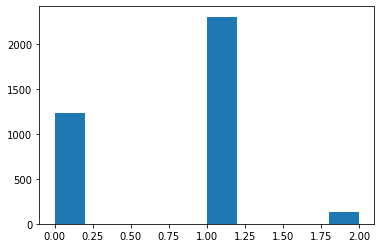

In [7]:
# This is highly unbalanced by default
_ = plt.hist(y_train)

In [8]:
# Baseline accuracy
from sklearn.dummy import DummyClassifier
DummyClassifier().fit(X_train, y_train).score(X_test, y_test)

0.6285714285714286

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Comments are appreciated.

In [9]:
# TODO: define a suitable neural network.

## Define the architecture of the model
## Initialize the constructor
net = tf.keras.Sequential()

## Add an input layer 
net.add(tf.keras.layers.Dense(12, activation = "relu"))

## Add one hidden layer 
net.add(tf.keras.layers.Dense(9, activation = "relu"))

## Add an output layer 
net.add(tf.keras.layers.Dense(3, activation = "softmax"))

In [10]:
# TODO: train the neural network.

## Compile the model
net.compile(optimizer = "adam", 
            loss = "sparse_categorical_crossentropy",
            metrics = ["sparse_categorical_accuracy"])

## Train the model
history_model = net.fit(X_train, y_train, epochs = 30)

Epoch 1/30
115/115 [==============================] - 1s 2ms/step - loss: 0.9755 - sparse_categorical_accuracy: 0.5437
Epoch 2/30
115/115 [==============================] - 1s 4ms/step - loss: 0.7350 - sparse_categorical_accuracy: 0.6842
Epoch 3/30
115/115 [==============================] - 0s 4ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.7051
Epoch 4/30
115/115 [==============================] - 0s 3ms/step - loss: 0.6711 - sparse_categorical_accuracy: 0.7149
Epoch 5/30
115/115 [==============================] - 1s 5ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.7215
Epoch 6/30
115/115 [==============================] - 1s 4ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.7253
Epoch 7/30
115/115 [==============================] - 0s 4ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.7296
Epoch 8/30
115/115 [==============================] - 1s 4ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7351
Epoch 9/30
115/115 [============================

In [11]:
# TODO: test the neural network and print the result on screen.
loss, acc  = net.evaluate(X_test, y_test, verbose = 0)
print("Test Accuracy: %.3f" % acc)
print("--------------------")
print("Loss: %.3f" % loss)

Test Accuracy: 0.742
--------------------
Loss: 0.604


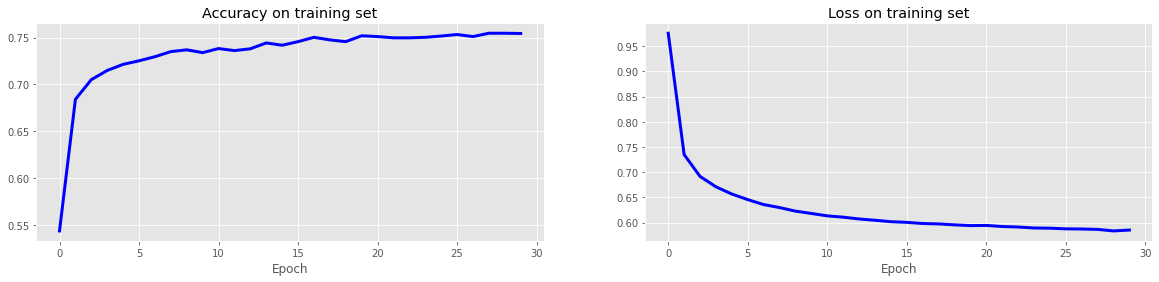

In [12]:
## Plot loss and accuracy for training test
plt.style.use("ggplot")

## Accuracy
plt.figure(figsize = (20, 4))
plt.subplot(121)
plt.plot(history_model.history["sparse_categorical_accuracy"], label = "Accuracy", linewidth = 3, color = "blue")
plt.xlabel("Epoch")
plt.title("Accuracy on training set")

## Loss
plt.subplot(122)
plt.plot(history_model.history["loss"], label = "Loss", linewidth = 3, color = "blue")
plt.xlabel("Epoch")
plt.title("Loss on training set")
plt.show()

### Comment
To solve this exercise a very simple network made up of three layers (input, hidden, output) has been implemented. For the first two layers the Relu was used as an activation function and for the last layer the Softmax function.

Hence, the network was compiled by *optimizer Adam*, *sparse categorical cross-entropy* and *sparse categorical accuracy*.

In conclusion, the network has been trained for 30 epochs.

### Exercise 2: Confidence histogram of the network (1 point)

🟥 Before starting, read carefully at least Sections 1 and 2 of the following paper: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.04599) (which we also discussed in class). We will refer to the paper as (Guo et al., 2017).

The purpose of this exercise is to replicate a confidence histogram *computed over the test set*, which is Fig. 1 in (Guo et al., 2017), top-left figure. The plot should include:
1. The distribution of the network's confidence (corresponding to **the highest output probability**);
2. The average accuracy of the network;
3. The average confidence of the network.

✅ **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.

In [13]:
# To start: this is the number of bins for the histogram and the corresponding values. You are free to modify the number of bins.
num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins)
print(bins)

tf.Tensor(
[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ], shape=(10,), dtype=float32)


In [14]:
## Compute the distribution of the network's confidence
y_pred     = net.predict(X_test)
y_pred_idx = tf.math.argmax(y_pred, axis = 1)

conf   = tf.math.reduce_max(y_pred, axis = 1)

## Compute the average accuracy of the network
avg_acc = acc

## Compute the average confidence of the network
avg_conf = tf.reduce_mean(conf)

39/39 [==============================] - 0s 4ms/step


In [15]:
## Check
print("Avg. Accuracy: %.3f" % avg_acc)
print("----------------------")
print("Avg. Confidence: %.3f" % avg_conf)

Avg. Accuracy: 0.742
----------------------
Avg. Confidence: 0.753


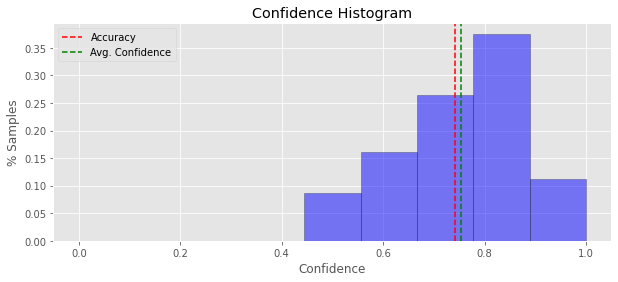

In [16]:
# TODO: plot the confidence histogram.
plt.figure(figsize = (10, 4))
plt.hist(conf, facecolor = "blue", alpha = 0.5, weights =  tf.ones(len(conf))/ len(conf), bins = bins, edgecolor = "black")
plt.axvline(x = avg_acc, color = "red", linestyle = "--", label = "Accuracy")
plt.axvline(x = avg_conf, color = "green", linestyle = "--", label = "Avg. Confidence")
plt.xlabel("Confidence")
plt.ylabel("% Samples")
plt.title("Confidence Histogram")
plt.legend(loc = "upper left")

The confidence histogram shows how many test examples are in each bin. Here, we used 10 bins and we can see that most predictions of this model have a confidence > 0.6.

The two vertical lines indicate the accuracy and the average confidence. The closer they are, the more calibrated the model will be.

### Exercise 3: Reliability diagrams (1 point)

This is similar to exercise 2, but you need to plot a **reliability diagram**, which is the bottom-left figure in Fig. 1 from (Guo et al., 2017). For this figure you need:

1. The histogram of the average accuracy of the network for each bin.
2. A superimposed histogram of the average confidence for each bin.
3. A diagonal line showing perfect calibration.

☝ **Hint**: the `Discretization` layer from TF may be useful: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization

🟩 **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.


In [17]:
## Define a function to compute the accuracy
def accuracy(ytrue, ypred):
    pred = tf.cast(ypred, dtype = tf.float64)
    res = tf.reduce_mean(tf.cast(ytrue == pred, tf.float64))
    return res

In [18]:
## Compute the accuracy for each bin
layer    = tf.keras.layers.Discretization(bin_boundaries = bins)
idx_bins = layer(conf)

def compute_acc_bins(num_bins, ytest, ypred, idx, confidence):
    acc_res  = []
    conf_res = []
    bin_cnt  = []
    
    for b in range(num_bins):
        idx_match = tf.where(idx == b)
        bin_cnt.append(len(idx_match))
        
        if len(idx_match) > 0:
            ## Matching index
            y_test_value = tf.gather(ytest, indices = [idx_match])
            y_pred_value = tf.gather(ypred, indices = [idx_match])

            ## Compute accuracy and confidence
            acc = accuracy(y_test_value, y_pred_value)
            conf = tf.reduce_mean(tf.gather(confidence, indices = [idx_match]))

            ## Add to lists
            acc_res.append(tf.keras.backend.get_value(acc))
            conf_res.append(tf.keras.backend.get_value(conf))
            
        else:
            acc_res.append(0)
            conf_res.append(0)

    ## Return metrics
    return {"accuracy": acc_res, 
            "confidence": conf_res,
            "prop_samples": bin_cnt}

In [19]:
## Check
metrics = compute_acc_bins(num_bins, y_test, y_pred_idx, idx_bins, conf)

In [20]:
## Compute gaps
gaps = tf.math.abs([el1 - el2 for el1, el2 in zip(metrics["accuracy"], metrics["confidence"])])
print("Gap is:", list(tf.keras.backend.get_value(gaps)))

Gap is: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0031523558, 0.04911287, 0.022500284, 0.01810183, 0.056178603]


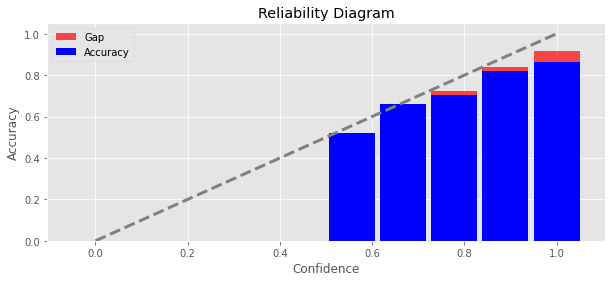

In [21]:
# TODO: plot the reliability diagram.
plt.figure(figsize = (10, 4))
plt.bar(bins, metrics["confidence"], color = "red", width = -0.1, label = "Gap", alpha = 0.7)
plt.bar(bins, metrics["accuracy"], color = "blue", width = -0.1, label = "Accuracy")
plt.plot([0, 1], [0, 1], linestyle = "dashed", linewidth = 3, color = "grey")
plt.title("Reliability Diagram")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.legend(loc = "upper left")

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what does the previous diagrams tell you about the calibration of the neural network?


### Comment
The reliability diagram shows the expected sample accuracy as a function of confidence for each bin.
The diagonal is the ideal accuracy for each confidence level.

In this case, we can see that the model is well calibrated, in fact the *gaps* between accuracy and confidence that are represented by the red bars are very small. 


In particular, the model is:
- perfect-calibrated for the bins [0.5; 0.6] and [0.6; 0.7] and slightly underconfidence for the other bins, but in general the performance is excellent, as we can see also looking at the ECE calculated below.

### Exercise 4: Expected calibration error, ECE (0.5 points)

For this exercise, you need to compute and print on screen the ECE, which is Eq. (3) from (Guo et al., 2017).

☝ **Hint(s)**: you should have computed almost everything already for Exercise 3. If you have NaN issues, you may want to check for empty bins.

🟩 **Completion requirement**: print the ECE.

In [22]:
# TODO: compute and print the ECE for the network.
print("Expected Calibration Error:", tf.keras.backend.get_value(tf.reduce_sum(tf.math.multiply(gaps, metrics["prop_samples"]) / X_test.shape[0])))

Expected Calibration Error: 0.027269859


### Exercise 5: Calibrating with the focal loss (1 point)

🟥 Before proceeding, read carefully the following paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). We'll refer to it as (Mukhoti et al., 2020).

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

☝ In order to implement a new loss function in TF, you need to subclass [tf.keras.losses.Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss). Read carefully the link.

🟩 **Completion requirement**: complete the `FocalLoss` implementation below. Instantiate a new network, train with the new focal loss, and check the resulting confidence histogram, reliability diagram, and ECE.


In [23]:
class FocalLoss(tf.keras.losses.Loss):
    # TODO: complete implementation

    ## loss = -*((1-y_c)^gamma)*log(y_c)
    def __init__(self, gamma = 2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def call(self, y_true, y_pred):
        ## y_pred is the prediction
        ## y_test is the ground truth
        c = tf.cast(y_true, dtype = tf.int32)
        y_c = y_pred * tf.one_hot(c, depth = 3)

        ## compute cross entropy
        csse = tf.keras.losses.SparseCategoricalCrossentropy()
        ce   = csse(y_true, y_pred)
        
        ## compute focal loss
        mod_fac = tf.pow((1 - y_c), self.gamma)
        loss = ce * mod_fac
        loss = tf.reduce_mean(loss, axis = 1)
        return  loss

In [24]:
# TODO: Train a second neural network with the FocalLoss object.

## Instantiate the model
net_focal_loss = tf.keras.Sequential()

net_focal_loss.add(tf.keras.layers.Dense(12, activation = "relu"))
net_focal_loss.add(tf.keras.layers.Dense(6, activation = "relu"))
net_focal_loss.add(tf.keras.layers.Dense(3, activation = "softmax"))

## Compile
net_focal_loss.compile(optimizer = "adam",
                       loss = FocalLoss(),
                       metrics = ["sparse_categorical_accuracy"])

## Fit
history_model_focal_loss = net_focal_loss.fit(X_train, y_train, epochs = 30)

Epoch 1/30
115/115 [==============================] - 1s 3ms/step - loss: 1.0463 - sparse_categorical_accuracy: 0.3150
Epoch 2/30
115/115 [==============================] - 0s 3ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.6395
Epoch 3/30
115/115 [==============================] - 0s 2ms/step - loss: 0.5835 - sparse_categorical_accuracy: 0.6796
Epoch 4/30
115/115 [==============================] - 0s 2ms/step - loss: 0.5382 - sparse_categorical_accuracy: 0.7019
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.7174
Epoch 6/30
115/115 [==============================] - 0s 3ms/step - loss: 0.5079 - sparse_categorical_accuracy: 0.7190
Epoch 7/30
115/115 [==============================] - 0s 2ms/step - loss: 0.4985 - sparse_categorical_accuracy: 0.7218
Epoch 8/30
115/115 [==============================] - 0s 2ms/step - loss: 0.4935 - sparse_categorical_accuracy: 0.7277
Epoch 9/30
115/115 [============================

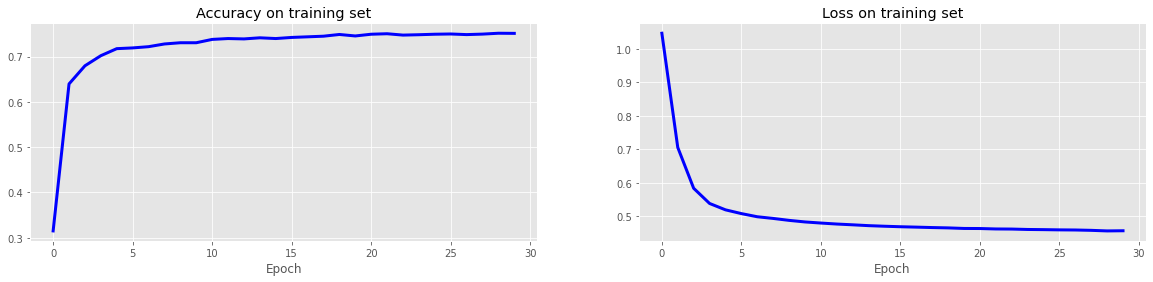

In [25]:
## Plot loss and accuracy for training test

## Accuracy
plt.figure(figsize = (20, 4))
plt.subplot(121)
plt.plot(history_model_focal_loss.history["sparse_categorical_accuracy"], linewidth = 3, color = "blue")
plt.xlabel("Epoch")
plt.title("Accuracy on training set")

## Loss
plt.subplot(122)
plt.plot(history_model_focal_loss.history["loss"], linewidth = 3, color = "blue")
plt.xlabel("Epoch")
plt.title("Loss on training set")
plt.show()

In [26]:
## Performance on test set
loss_focal, acc_focal  = net_focal_loss.evaluate(X_test, y_test, verbose = 0)
print("Test Accuracy with Focal Loss: %.3f" % acc_focal)
print("--------------------")
print("Focal Loss: %.3f" % loss_focal)

Test Accuracy with Focal Loss: 0.724
--------------------
Focal Loss: 0.478


In [27]:
## Compute the distribution of the network's confidence
y_pred_focal_loss     = net_focal_loss.predict(X_test)
y_pred_focal_loss_idx = tf.math.argmax(y_pred_focal_loss, axis = 1)

conf_focal_loss   = tf.math.reduce_max(y_pred_focal_loss, axis = 1)

## Compute the average accuracy of the network
avg_acc_focal_loss = acc_focal

## Compute the average confidence of the network
avg_conf_focal_loss = tf.reduce_mean(conf_focal_loss)

39/39 [==============================] - 0s 1ms/step


In [28]:
## Check
print("Avg. Accuracy: %.3f" % avg_acc_focal_loss)
print("----------------------")
print("Avg. Confidence: %.3f" % avg_conf_focal_loss)

Avg. Accuracy: 0.724
----------------------
Avg. Confidence: 0.738


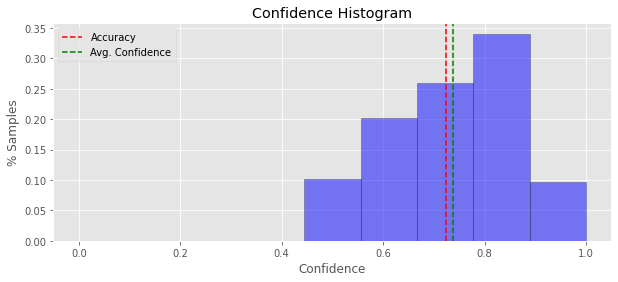

In [29]:
# TODO: plot confidence histogram, reliability diagram, and print the ECE of the new network.
plt.figure(figsize = (10, 4))
plt.hist(conf_focal_loss, facecolor = "blue", alpha = 0.5, weights =  tf.ones(len(conf_focal_loss))/ len(conf_focal_loss), bins = bins, edgecolor = "black")
plt.axvline(x = avg_acc_focal_loss, color = "red", linestyle = "--", label = "Accuracy")
plt.axvline(x = avg_conf_focal_loss, color = "green", linestyle = "--", label = "Avg. Confidence")
plt.xlabel("Confidence")
plt.ylabel("% Samples")
plt.title("Confidence Histogram")
plt.legend(loc = "upper left")

In [30]:
## Check
layer    = tf.keras.layers.Discretization(bin_boundaries = bins)
idx_bins_focal_loss = layer(conf_focal_loss)

metrics_focal_loss = compute_acc_bins(num_bins, y_test, y_pred_focal_loss_idx, idx_bins_focal_loss, conf_focal_loss)

In [31]:
## Compute gaps
gaps_focal_loss = tf.math.abs([el1 - el2 for el1, el2 in zip(metrics_focal_loss["accuracy"], metrics_focal_loss["confidence"])])
print("Gap is:", list(tf.keras.backend.get_value(gaps_focal_loss)))

Gap is: [0.0, 0.0, 0.0, 0.0, 0.0, 0.017476121, 0.026016833, 0.013246192, 0.0049014986, 0.059973426]


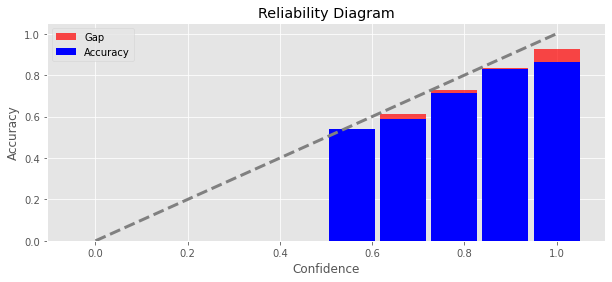

In [32]:
# TODO: plot the reliability diagram.
plt.figure(figsize = (10, 4))
plt.bar(bins, metrics_focal_loss["confidence"], color = "red", width = 0.1, label = "Gap", alpha = 0.7)
plt.bar(bins, metrics_focal_loss["accuracy"], color = "blue",  width = 0.1, label = "Accuracy")
plt.plot([0, 1], [0, 1], linestyle = "dashed", linewidth = 3, color = "grey")
plt.title("Reliability Diagram")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.legend(loc = "upper left")

In [33]:
## TODO: print the ECE of the new network.
print("Expected Calibration Error:", tf.keras.backend.get_value(tf.reduce_sum(tf.math.multiply(gaps_focal_loss,
                                                                                            metrics_focal_loss["prop_samples"]) / X_test.shape[0])))

Expected Calibration Error: 0.017947957


🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what can you tell about the calibration of this second neural network?

### Comment

We can see that using the Focal Loss, there is a slight improvement in terms of ECE probably given by the bin [0.7; 0.8] and [0.8; 0.9] that are more calibrated with respect to same bins without the focal loss, but the model is less calibrated on the bin [0.6; 0.7]. 
 
In general, also using this new loss the model is  well calibrated

### Exercise 5: Conformal prediction (1 point)

🟥 Before proceeding, read **Section 1** from the following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). We'll refer to it as (Angelopoulos and Bates, 2021). Note that this material *was not covered in class*.

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. For the purpose of this exercise, you need to implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

☝ **Hints**: In practice, you would need a separate validation set. For the purpose of this exercise, you can use the previously defined test set for everything. For computing the **quantile**, you are allowed to use NumPy or TensorFlow Probability.

🟩 **Completion requirement**: Replicate the pseudocode from Fig. 2 of (Angelopoulos and Bates, 2021) in TF and apply it on the trained neural network. Plot a histogram showing the distribution of the sizes of the output sets, when the network is run on the entire test set.

In [34]:
# Implement the CP procedure

## Step 1
## Set error rate value
alpha  = 0.05

## Get conformal scores
y_pred_soft = net.predict(X_test)
idx_y_test  = tf.cast(y_test, tf.int32).numpy()

## Compute softmax output
softmax_output = y_pred_soft[range(y_pred_soft.shape[0]), idx_y_test]

## Compute conformal scores
conformal_scores =  1 - softmax_output ## low value, good performance (1 - f(Xi)_yi)

39/39 [==============================] - 0s 1ms/step


In [35]:
## Step 2 - get adjusted quantile and compute prediction sets
import numpy as np
n = y_test.shape[0]

q_level = np.ceil((n + 1) * (1 - alpha))/n
q_hat   = np.quantile(conformal_scores, q_level,
                      interpolation = "higher")
prediction_sets = y_pred_soft >= (1 - q_hat)

In [36]:
## Preparing plot
ps = np.sum(prediction_sets, axis = 1)
values, counts = np.unique(ps, return_counts = True)
print("Values:", values, "Count", counts)

Values: [1 2 3] Count [304 919   2]


Text(0.5, 1.0, 'Size of the output set')

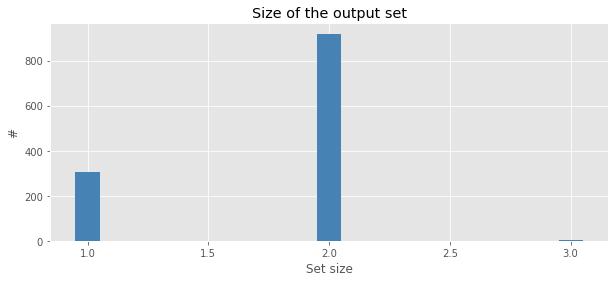

In [37]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).
plt.figure(figsize = (10, 4))
plt.bar(values, counts, color = "steelblue", width = 0.1)
plt.xlabel("Set size")
plt.ylabel("#")
plt.title("Size of the output set")

### Comment
With $\alpha = 0.05$ and it's possible to see that the network with the 95% probability the correct class is between two possible classes. This is given by the fact that the dataset is highly unbalanced.

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 14/11/2022 23:59** on the Google Classrom page.

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.